<a href="https://colab.research.google.com/github/conniaren/GenotypeImputationProject/blob/master/1-Data-exploration/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
from google.colab import files
import io
upload = files.upload()

Saving output_matrix.npz to output_matrix.npz


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Analysis
The dataset is a sparse matrix of genotypes encoded by the number of minor alleles at each loci: 0-> no minor alleles, 1-> minor allele on one chromosome, 2-> minor alleles on both chromosomes. The number of individuals in the sample dataset is 503, but the total number of individuals in phase 3 of 1000 genome project is 2577. The total number of variants (features) in the sample set is 264 695. Hence, this matrix is of size (503 x 264695). As of currently, there are no distinguishable missing values in the dataset due to the way the matrix was constructed.

The number of individuals in the output matrix is 
503
The total number of individuals in the 1000 genome project (Phase3) is 2577 individuals. 
Source: ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/20131219.populations.tsv
The number of variants is 
264695
The number of non-zero entries in the matrix is: 38 220 336 (count_nonzero())
This indicates the number of zero entires in the matrix is 94 921 249. 
However this does not indicate the number of missing entries as 0 can also indicate no minor allele present.
503


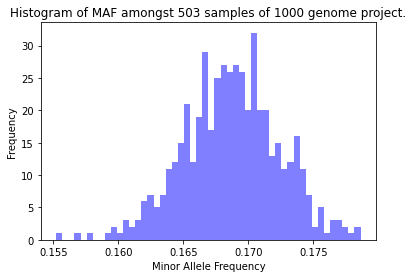

In [2]:
dataset = sparse.load_npz('output_matrix.npz')
dataset_csr = dataset.tocsr()
print("The number of individuals in the output matrix is ")
print (dataset.shape[0])
print("The total number of individuals in the 1000 genome project (Phase3) is 2577 individuals. \nSource: ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/20131219.populations.tsv")
print("The number of variants is ")
print(dataset.shape[1])
print("The number of non-zero entries in the matrix is: 38 220 336 (count_nonzero())")
print ("This indicates the number of zero entires in the matrix is 94 921 249. \nHowever this does not indicate the number of missing entries as 0 can also indicate no minor allele present.")

import numpy as np 

average_minor_alleles = np.mean(dataset.todense(),axis = 1)
#average_minor_alleles = np.round(average_minor_alleles.data,2)
minor_allele_freq = average_minor_alleles/2

print(len(minor_allele_freq))

num_bins = 50
# the histogram of the data

n, bins, patches = plt.hist(minor_allele_freq, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Minor Allele Frequency')
plt.ylabel('Frequency')
plt.title(r'Histogram of MAF amongst 503 samples of 1000 genome project.')
plt.show()


#MAF
When looking at the of histogram of the Minor Allele Frequency of all variants in the dataset, we can see a downward curving trend of minor alleles with low frequencies being most common and high frequency minor alleles being rare. This is the typical result expected in a random sample of healthy individuals in a population as minor allele mutations are less frequent. 

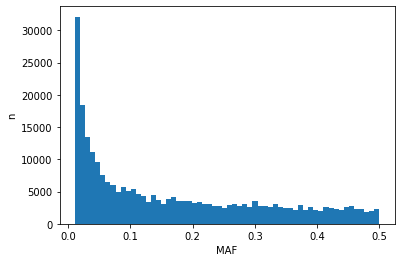

In [ ]:
# MARC
# Here is the correct code for the MAF. Sorry about the confusion.
dense = dataset.todense()
freqs = np.nanmean(dense, axis=0) / 2
freqs_vec = np.array(freqs)[0, :]

plt.hist(freqs_vec, bins=60)
plt.xlabel("MAF")
_ = plt.ylabel("n")

#Linkage Disequilibrium and Correlation
In a non-random fashion, alleles at seperate loci may associate with one another, this is known as linkage disequilibrium in a genome. We can use correlation as a proxy to determine which regions or pairs of alleles are under strong positive or negative association. From the heatmap below, we can see between the first 265 loci in the dataset there is a very strong positive correlation within the region of 85 to 230. There are also certain subregions within that show strong negative correlation with loci 230 to 255. It is evident that within a random section of the dataset, there is strong and sufficient correlation between alleles that allows us to form a basis for our imputation model. 

[[ 1.49657570e+00 -4.96479446e-01  4.67304516e-01 ... -1.68353901e-02
  -1.68353901e-02 -1.32390777e-02]
 [-4.96479446e-01  3.93764131e+00 -8.05795707e-01 ... -8.53136043e-01
  -8.53136043e-01 -9.66524506e-01]
 [ 4.67304516e-01 -8.05795707e-01  3.24929231e+00 ... -1.75739594e+00
  -1.75739594e+00 -1.85643119e+00]
 ...
 [-1.68353901e-02 -8.53136043e-01 -1.75739594e+00 ...  3.93453444e+01
   3.93453444e+01  3.91680153e+01]
 [-1.68353901e-02 -8.53136043e-01 -1.75739594e+00 ...  3.93453444e+01
   3.93453444e+01  3.91680153e+01]
 [-1.32390777e-02 -9.66524506e-01 -1.85643119e+00 ...  3.91680153e+01
   3.91680153e+01  3.91086851e+01]]


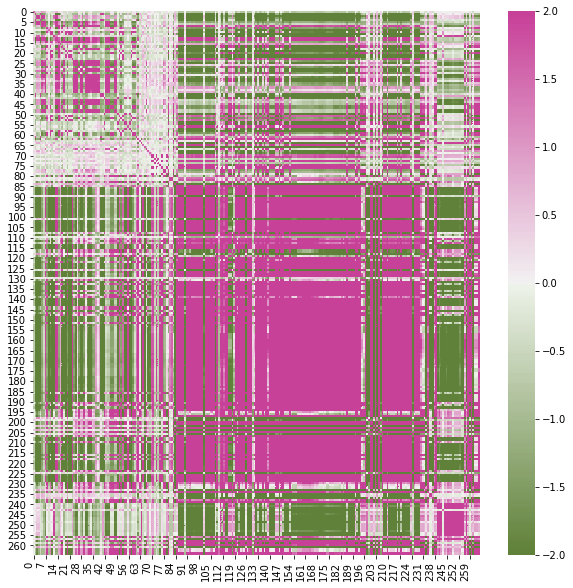

In [49]:
    subset_alleles = dataset.todense()[:,0:265]
    
    x = (~np.isnan(subset_alleles)).astype(int)
    x = np.dot(x.T, x)

    #standardize values
    standard = (subset_alleles-np.nanmean(subset_alleles, axis = 0))/ np.nanstd(subset_alleles, axis = 0)
    #standard[np.isnan(standard)] = 0
    r = np.dot(standard.T, standard) / x
    correlation_coeff = r**2
    print(correlation_coeff)

    import seaborn as sns

    plt.figure(figsize = (10,10))

    ax = sns.heatmap(
    correlation_coeff, 
    vmin=-2, vmax=2, center=0,
    cmap=sns.diverging_palette(111, 333, n=200)
)
    ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

# Data Loader

In [ ]:
import torch 
from torch.utils.data import DataLoader, TensorDataset

genotype_dataset = TensorDataset(torch.tensor(dataset.todense(), dtype=torch.float64))
dataloader = DataLoader(genotype_dataset, batch_size = 10, shuffle = True, num_workers=2, pin_memory=True)

for (x,y) in enumerate(dataloader):
    print(x) #iteration
    print(y)
    print(y[0].shape)
    if (x ==5):
      break

0
[tensor([[0., 0., 0.,  ..., 0., 2., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 2., 2., 0.],
        [0., 1., 0.,  ..., 2., 2., 0.]], dtype=torch.float64)]
torch.Size([10, 264695])
1
[tensor([[0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 2.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)]
torch.Size([10, 264695])
2
[tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 2., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)]
torch.Size([10, 264695])
3
[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.],
     